# ACSE-7 Inversion & Optimisation - Part C (15 pts) <a class="tocSkip"></a>

This question covers lecture 8 on Data Assimilation methods only.

Please read the general instructions in [README.md](./README.md) first!

## Probability

The exponential distribution is a one parameter distribution with a probability density

$$ p(x):=\begin{cases}
\lambda\exp\left(-\lambda x\right), & x>0,\\
0, & \mbox{otherwise}
\end{cases}$$

for a known value of $\lambda$, which is the reciprocal of the mean of the distribution. Random number generators for this distribution are implementated in regular Python as `random.expovariate` and in numpy as `numpy.random.exponential`.

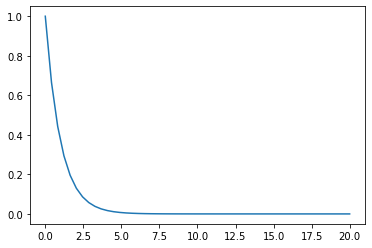

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
np.set_printoptions(suppress=True)

x = np.linspace(0, 20)
lmd = 1.0
plt.plot(x, lmd*np.exp(-lmd*x))

### Question C1

Calculate the formula for the cumulative distribution function $P(X\leq z) = \int_{-\infty}^z p(x)dx$ for the exponential PDF given above. Write python code to plot this CDF function against a histogram of at least 1000 samples from one of the implementations above using the scale factor $\lambda=1$ over the range $x\in[0,20]$.

### Answer for C1
The CDF for $P(X\leq z) = \int_{-\infty}^z p(x)dx$ of the exponential is (of any $\lambda$):
$$
P(X\leq z) = \int_{-\infty}^z p(x)dx = \begin{cases}
1 - \exp\left(-\lambda z\right), & z >0,\\
0, & \mbox{otherwise}
\end{cases}
$$

The plot for this CDF function is:

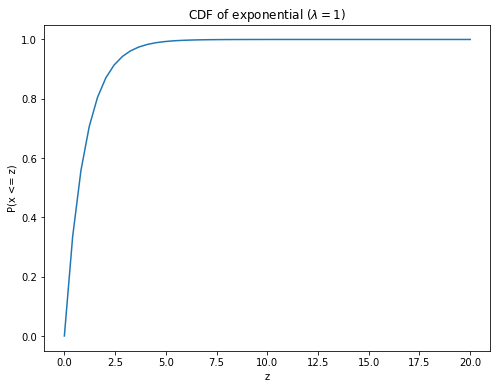

In [4]:
# define our cdf
def CDF(x, lamda):
    z = np.zeros_like(x)
    z[x > 0] = 1 - np.exp(-lamda * x[x > 0])
    z[x < 0] = 0
    return z
    
#plot my CDF function, note here I choose lamda = 1
plt.figure(figsize=(8, 6))
plt.plot(x, CDF(x, 1))
plt.xlabel('z')
plt.ylabel('P(x <= z)')
plt.title(r'CDF of exponential ($\lambda = 1$)')
plt.show()

And the plot this CDF function against a **histogram** of at least 10000000 samples is: 

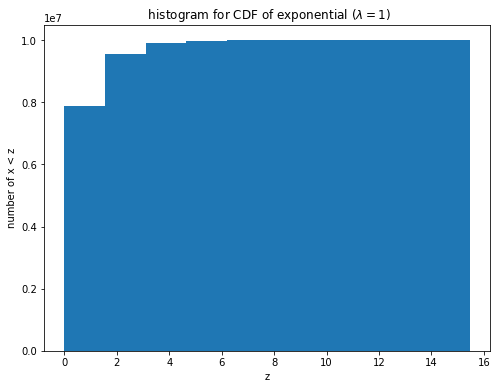

In [5]:
plt.figure(figsize=(8, 6))
# take 10000000 samples
n = 10000000
data = np.random.exponential(scale=1.0, size = n)
# plot the histogram, note we are plotting a CDF, so we turn on the 'cumulative' option.
plt.hist(data, cumulative=True)
plt.xlabel('z')
plt.ylabel('number of x < z')
plt.title(r' histogram for CDF of exponential ($\lambda = 1$)')
plt.show()

## Data Assimilation


A set of $N_1$ particles move in 2D space. The vector of their positions $\mathbf{x}$, where  $$\mathbf{x}=\{\mbox{x-coordinate of particle 1}, \mbox{y-coordinate of particle 1}, \ldots, \mbox{y-coordinate of particle $N_1$}\} $$  can be modelled forward in time using an equation
$$\mathbf{x}_{i+1}=\mathbf{M}\mathbf{x}_i+\mathbf{f}$$
for a known fixed linear update model $\mathbf{M}$ and forcing vector $\mathbf{f}$. You have been asked to forecast the future positions of the particles, and are provided with a photograph of their current state. It is believed that the vector, $\mathbf{y}$, of the intensities of the $N_2$ pixels of the photograph, satisfies a relation approximately proportional to the sum of the sum of the inverse squares of the distances of their pixel centres from the particle sources.

That is to say that for a pixel at position $\mathbf{q}$
its intensity is
$$I= k\sum_{\mathbf{r}\in\mathbf{x}}\frac{1}{a+\|\mathbf{q}-\mathbf{r}\|^2}.$$
for known constants $k$ and $a$. This implicitly defines an observation operator, $\mathbf{h}(\mathbf{x})$. 

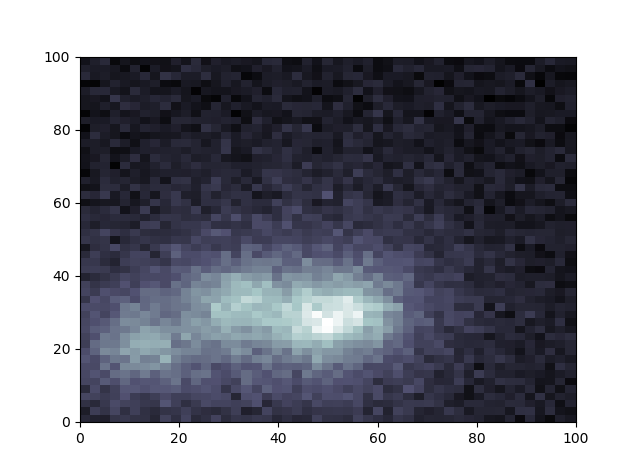

You may assusme that $N_1\ll N_2$. You are also provided with estimates for the error covariance matrices for the background state, $\mathbf{B}$, the model, $\mathbf{Q}$, and the observations, $\mathbf{R}$, with all errors assumed Gaussian.


### Question C2:

Write Python code to implement the observation operator described above in a format appropriate for data assimilation methods. You can assume that the input state vector $\mathbf{x}$  is a length $2N_1$ vector, giving the 2D spatial coordinates of the first point, then the 2nd and so on, and that that your function will also be provided with a $2\times N_2$ array containing the $\mathbf{q}$ positions of the pixels, as well a $k$ value.

### Answer for C2
The observation operator $\mathbf{h}(\mathbf{x})$ is implemented by the code below:

In [146]:
def h(x, q, a, k=1.0):
    """Calculate expected observation for a given state vector.
    
    Parameters
    ----------
    
    x: ndarray
        1d array of length 2N_1 containing point positions
    q: ndarray
        2d array of length [2, N_2] containing pixel centre positions
    k: float
        scaling coefficient
    a: float
        weighting coefficient
        
    
    
    Result
    ------
    y: 1d array of length N_2 containing expected intensities
    
    """
    # we first reshape x into a collection of 2-d points
    x_2d = np.array(x).reshape((int(len(x)/2), 2))
    # we also reshape q into a collection of 2-d points.
    q_2d = np.array(q).T
    # we set up the result array y to store the intensities of pixels
    y = np.zeros(q_2d.shape[0])
    # calculating the intensity for each pixel
    for i in range(q_2d.shape[0]):
        y[i] = np.sum(1 / (np.sum((x_2d - q_2d[i])**2, axis = 1) + a)) * k
    
    return y

With an example: <br>
$\boldsymbol{x}$ a random int array of length 10
and $\boldsymbol{q} $ is a 20 $\times$ 20 square mesh grid.


In [147]:
x = np.zeros(10)
for i in range(10):
    x[i] = np.random.randint(15, 25)

points = [i for i in range(20)]
mesh = np.meshgrid(points,points)
q = np.array(mesh[0].reshape(1, len(mesh[0]) ** 2))
q = np.vstack((q, mesh[1].reshape(1, len(mesh[1]) ** 2)))

print("x:", x)
print("q:", q)

x: [19. 23. 22. 21. 19. 17. 19. 15. 19. 15.]
q: [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3
   4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7
   8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7  8  9 10 11
  12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
  16 17 18 19  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3
   4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7
   8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7  8  9 10 11
  12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
  16 17 18 19  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3
   4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7
   8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7  8

Compute `h(x, q, a, k)` for $a = 1$ and $k = 2$:

In [148]:
y = h(x, q, 1, 2)
print("intensities:\n", y)

intensities:
 [0.014291   0.01513698 0.01603852 0.01699695 0.01801265 0.0190847
 0.02021044 0.02138497 0.02260055 0.02384607 0.02510644 0.02636222
 0.02758943 0.02875981 0.02984163 0.0308012  0.03160492 0.032222
 0.03262729 0.03280384 0.01502866 0.01596737 0.01697431 0.01805238
 0.01920357 0.02042854 0.02172604 0.02309227 0.02452004 0.02599783
 0.02750894 0.0290306  0.03053344 0.03198147 0.03333286 0.03454181
 0.03556151 0.03634815 0.03686535 0.03708843 0.01579484 0.01683516
 0.01795874 0.01917063 0.02047512 0.02187529 0.02337227 0.02496438
 0.02664602 0.0284063  0.03022757 0.03208392 0.03393989 0.03574984
 0.03745844 0.03900283 0.04031672 0.04133642 0.04200806 0.04229469
 0.01658623 0.01773714 0.01898899 0.02034967 0.0218267  0.02342668
 0.02515445 0.02701202 0.02899709 0.03110114 0.03330713 0.03558697
 0.03789896 0.04018591 0.04237464 0.04437815 0.04610098 0.04744844
 0.0483385  0.04871405 0.01739828 0.01866862 0.02006041 0.02158529
 0.02325515 0.02508156 0.02707489 0.02924309 0.0315

###  Question C3

Consider the following list of potential data assimilation strategies:

- A single OI assimilation event
- A single 3D-Var assimilation event
- A single strong 4D-Var assimilation event
- iterations of the ordinary Kalman filter
- iterations of the extended Kalman filter

Place the five possible strategies in order from most appropriate to least appropriate in order to efficiently generate an accurate forcast at the future positions of the particles, given the information you have. For each strategy include a _short_ (i.e at least a sentence, but no more than a paragraph) explanation of why you have placed it where you have.

#### Write your answer to question C3 in this cell
### Answer for C3

Most appropriate<br>
  **1. A single 3D-Var assimilation event** <br>
  In this question, we have a nonlinear observation operator $\mathbf{h}$ (defined as above), and the covariance matrices for the background state, $\mathbf{B}$, the model, $\mathbf{Q}$, and the observations, $\mathbf{R}$, with all errors assumed Gaussian, and note we are only given a photograph here, which means only a single observation $\mathbf{y}$ is given, thus a single 3D-Var assimilation event would be the most perfered choice.<br>
  <br>**2. A single strong 4D-Var assimilation event**<br>
  As we have only a single observation $\mathbf{y}$, so actually the time-aware property of a strong 4D-Var is not useful here, as the functional to minimize would become $$ \begin{aligned}\mathcal{J}(\mathbf{x_0}) &= \frac{1}{2}\left[(\mathbf{x}_b-\mathbf{x_0})^T\mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x}_0)+\sum_{i=0}^{0}(\mathbf{y}-h_i(\mathbf{x}(t_i))))^T\mathbf{R}_i^{-1}(\mathbf{y}-h_i(\mathbf{x}(t_i)))\right] \text{with}\; \mathbf{x}(t_0) = \mathbf{x}_0\\&=\frac{1}{2}\left[(\mathbf{x}_b-\mathbf{x_0})^T\mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x}_0)+(\mathbf{y}-h_0(\mathbf{x}_0)))^T\mathbf{R}_i^{-1}(\mathbf{y}-h_0(\mathbf{x}_0))\right]\end{aligned} $$ which means the implementation of a strong 4D-Var should be equivalent to a 3D-Var here (if we express $x_0$ with $x_a$), as it can achieve the equivalent effect but would be unnecessary to implement its full version in this question, so I place it as the second here.<br>
  <br>**3. iterations of the extended Kalman filter**<br>
  If we have only one single observation, then no further iterations of Kalman filters are needed, as the step 0 of 
  extended Kalman filter would give us $$\tag{1} \mathbf{x}_a = \mathbf{x}_b + \mathbf{B} \mathbf{H}^T\left( \mathbf{R} + \mathbf{H}\mathbf{B}\mathbf{H}^T\right)^{-1} (\mathbf{y}-\mathbf{h}(\mathbf{x}_b))$$ where $\mathbf{H} = \frac{\partial \mathbf{h}}{\partial \mathbf{x}}$ is the tangent linear model with $H_{ij} := \frac{\partial h_i}{\partial x_j}$ and $\mathbf{H}^T$ is the adjoint, note that the functional we want to minimize in 3D-var:
  $$\mathcal{J}(\mathbf{x}) = (\mathbf{x}_b-\mathbf{x})^T\mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x})+(\mathbf{y}-\mathbf{h}(\mathbf{x}))^T\mathbf{R}^{-1}(\mathbf{y}-\mathbf{h}(\mathbf{x})) $$ taking its total derivative w.r.t $\mathbf{x}$, $$\begin{aligned}\mathcal{J}'(\mathbf{x}) = \nabla_\mathbf{x}\mathcal{J} &= 2 \cdot \mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x}) - \mathbf{H}^T \cdot\left((\mathbf{R}^{-1})^T\,(\mathbf{y}-\mathbf{h}(\mathbf{x})) + \mathbf{R}^{-1}\,(\mathbf{y}-\mathbf{h}(\mathbf{x})) \right) \\&= 2 \cdot \left(\mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x}) + \mathbf{H}^T \mathbf{R}^{-1}\,(\mathbf{y}-\mathbf{h}(\mathbf{x})\right) \end{aligned}$$ and 
$$\begin{aligned} \mathcal{J}''(\mathbf{x}) = Hess(\mathbf{x}) &= -2 \left(\mathbf{B}^{-1} + \mathbf{H}^T \mathbf{R}^{-1}\mathbf{H} \right) \end{aligned},$$ so $$\mathbf{x}_b - Hess^{-1}(\mathbf{x}_b) \nabla_{\mathbf{x}_b} \mathcal{J} = \mathbf{x}_b + \left(\mathbf{B}^{-1} + \mathbf{H}^T|_{\mathbf{x} = \mathbf{x}_b} \mathbf{R}^{-1}\mathbf{H}|_{\mathbf{x} = \mathbf{x}_b}  \right)^{-1} \, \mathbf{H}^T|_{\mathbf{x} = \mathbf{x}_b}  \mathbf{R}^{-1}\,(\mathbf{y}-\mathbf{h}(\mathbf{x}_b)),$$ Note we have this equation equivalent to (1) (as we seen in tutorial 8), thus the extended Kalman filter would just give us $\mathbf{x}_a$ as a single step of Newton-Raphson method starting at $\mathbf{x}_b$. However, it does not garantee to reach at the minimum of our functional $\mathcal{J}$ (as $\mathbf{h}$ is non-linear, it can have higher order derivatives w.r.t $\mathbf{x}$ than 2, Note $\mathbf H$ is not a constant Matrix ), which would give a less optimal solution compared to 3D-Var. So I put it as the third place.

  <br>**4. iterations of the ordinary Kalman filter**<br>
  In this question, we have a non-linear observation operator $\mathbf{h}$, but the ordinary Kalman filter needs a linear observation operator $\mathbf H$ to update the forecast, as $$ \mathbf{x}_a = \mathbf{x}_b + \mathbf{B} \mathbf{H}^T\left( \mathbf{R} + \mathbf{H}\mathbf{B}\mathbf{H}^T\right)^{-1} (\mathbf{y}-\mathbf{H}\mathbf{x}_b),$$
  Thus it is not a feasiable method for this question.
  <br>**4. A single OI assimilation event**<br>
  As the same as ordinary Kalman filter, the single OI assimilation also needs a linear observation operator $\mathbf H$, which is not suitable for this question, thus I would place it also in the last place, as the ordinary Kalman filter.<br>
Least appropriate

### Question C4

How would your answer change if you were instead to be given a set of photographs at known times? Include a short explanation of any changes to your previous order that you make.

#### Write your answer to question C4 in this cell
### Answer for C4

Most appropriate

  <br>**1. iterations of the extended Kalman filter **<br>  
   
   As disccussed above, the extended Kalman filter could use information of observations over the time scales as well as handling a non-linear observation operator like $\mathbf h$ in this question. In our qustion, it follows 4 steps for each iteration:
   $$ \mathbf{x}^{k+1}_b = \mathbf{M}\mathbf{x}^k_b +\mathbf{f} \;\;\;\;\;\;...①$$
$$\mathbf{B}^{k+1} = \mathbf{M}\, \mathbf{P}^k\mathbf{M}^T +\mathbf{Q}\;\;\;\;\;\;...②$$
$$ \mathbf{x}^{k+1}_a = \mathbf{x}^{k+1}_b + \mathbf{B}^{k+1} \mathbf{H}^T\left( \mathbf{R} + \mathbf{H}\mathbf{B}\mathbf{H}^T\right)^{-1} (\mathbf{y}^{k+1}-\mathbf{h}_k(\mathbf{x}^{k+1}_b))\;\;\;\;\;\;...③$$
 $$\mathbf{P}^k = (\mathbf{I}-\mathbf{B}^{k+1}\mathbf{H}^T(\mathbf{R}+\mathbf{H}\mathbf{B}^{k+1}\mathbf{H}^T)^{-1}\mathbf{H})\mathbf{B}^{k+1}\;\;\;\;\;\;...④$$
 
 where $\mathbf{H} = \frac{\partial \mathbf{h}}{\partial \mathbf{x}}$ is the tangent linear model with $H_{ij} := \frac{\partial h_i}{\partial x_j}$.
 With this method, we keep traking and updating the background/analysis covarience $\mathbf B$ and $\mathbf P$, which could give us a relatively accurate Hessian and Jocabian for the current state of the Newton iteration step ③ (as I have discussed it in Question C3). And also, in this question, the dimension of our background state vector $N_1$ $\ll$ the dimension of the observation vector $N_2$, thus $\mathbf{M}, \mathbf{B}, \mathbf{Q}$ would not be large matrix compared to $\mathbf{H}, \mathbf{P}$, thus if we could implement $\mathbf{H}, \mathbf{P}$ in a sparse format and perform sparse Matrix multiplication in  ②, ③, ④ would largely improve the computational efficiency. However this method has drawback that if the model states increases, the covarience would be grow intractable. Or say, it won't work for too many photographs(observations) in this question.<br>
  <br>**2. A single strong 4D-Var assimilation event**<br>
  Because this time we have a set of photographs at known times, which indicates we should use these "information over time" to help us make our forecast. As our observation error $\mathbf B$ and background error $\mathbf R$ follow a Gaussian distribution, we could use the 4D-var. Suppose we have a series of obsevations $\left(\mathbf{y}_0,\mathbf{y}_1, \mathbf{y}_2, \mathbf{y}_3 ... \mathbf{y}_n\right)$, by solving the functional minima with constraints (using Lagrange Multipliers), the 4D-var would give us an optimal continuous/discontinuous interpolation $\mathbf x(t)$ in the whole time window, where $$\tag{2}\mathbf{x}_{k+1} = \mathbf{M}\,\mathbf{x}_{k} + \mathbf{f}$$ satisfying our model exactly and $\left(\mathbf{x}_0,\mathbf{x}_1, \mathbf{x}_2, \mathbf{x}_3 ... \mathbf{x}_n\right)$ is our analysis state corresponding to obsevation states $\left(\mathbf{y}_0,\mathbf{y}_1, \mathbf{y}_2, \mathbf{y}_3 ... \mathbf{y}_n\right)$. <br>
  However, note in this question, we are given that our model is not exactly precise and have a Gaussian distributed covariance matrix $\mathbf Q$, so our functional to minimize would actually become  $$\mathcal{J}_{ext}= \frac{1}{2} \left[(\mathbf{x}_b-\mathbf{x_0})^T\mathbf{B}^{-1}(\mathbf{x}_b-\mathbf{x}_0)+\sum_{i=0}^{N}(\mathbf{y}_i-\mathbf{h}_i(\mathbf{x}_i)))^T\mathbf{R}_i^{-1}(\mathbf{y}_i-\mathbf{h}_i(\mathbf{x}_i)) + \sum_{i=0}^N \left(\mathbf{x}_{i+1}-\mathbf{x}_i-\mathbf{m}(\mathbf{x}_i, t_i)\right)^T\mathbf{Q}^{-1}\left(\mathbf{x}_{i+1}-\mathbf{x}_i-\mathbf{m}(\mathbf{x}_i, t_i)\right)\right]$$
  Thus, an improvement to this method to get a more accurate optimal solution would be a modification to our update equation (2) to reduce the effect of the extra term, which leads to a $\underline{\text{Weak Constraint 4D-Var}}$, otherwise a correct optimum can not be found. This improment would also add an additional computational cost for the 4D-Var, so I place it in the 2rd place. <br>
  
  <br>**3. A single 3D-Var assimilation event **<br>
  
  In this question, we have a series of observation over time, but a single 3D-Var assimilation event ignores the concept of time, thus not a proper method for this question. A enhancement to this method would be multiple 3D-Var assimilation events, which assimilates data using 3D-Var in each time step. It would lead to larger computational cost but it can give some useful result, for this reason I place it as the 3rd place.<br>
  <br>**4. iterations of the ordinary Kalman filter**<br>
  
  As the same reason we have discussed in Question C3, the ordinary Kalman filter needs a linear observation operator $\mathbf H$ to update the forecast, for which reason it is not a feasiable method for this question. Thus I put it at the 4th place.
  
  <br>**4. A single OI assimilation event **<br>
  
  As the same reason we have discussed in Question C3, the single OI assimilation needs a linear observation operator $\mathbf H$, which is not suitable for this question, thus I would place it also in the last place, as the ordinary Kalman filter.<br>
  
Least appropriate

### Question C5

Further analysis reveals that the particle intensities above only register on the photograph above a given cut off value,

$$ I_\mbox{registered} = \begin{cases}
I-c,&I\geq c\\
0,&I<c
\end{cases}
$$
What additional difficulties does this create for the methods listed in your previous answers? Can you suggest any strategies to deal with this issue? You can include code or pseudo code in your answer if you need to.


#### Write your answer to Part C5 here. You may add additional markdown or code cells as needed.


### Answer for C5

Recall the $\mathbf{h}(\mathbf{x})$ we defined at C2, in this question, we could define a new observation operator $\widetilde{\mathbf{h}}(\mathbf{x})$, by

$$ \widetilde{\mathbf{h}} (\mathbf{x}) = \begin{cases}
\mathbf{h}(\mathbf{x}) -c,&\mathbf{h}(\mathbf{x})\geq c\\
0,&\mathbf{h}(\mathbf{x}) <c
\end{cases},
$$

thus we implement this new observation operator $\widetilde{\mathbf{h}}$ with a bit change, as the function `h_cutoff(x, q, a, k, c)` following:

In [149]:
def h_cutoff(x, q, a, k, c):
    """Calculate expected observation for a given state vector,
    follows the equation h(x) given in C2, but cut off the value 
    below a given constant c.
    
    Parameters
    ----------
    
    x: ndarray
        1d array of length 2N_1 containing point positions
    q: ndarray
        2d array of length [2, N_2] containing pixel centre positions
    k: float
        scaling coefficient
    a: float
        weighting coefficient
        
    
    
    Result
    ------
    y: 1d array of length N_2 containing expected intensities
    
    """
    # we first reshape x into a collection of 2-d points
    x_2d = np.array(x).reshape((int(len(x)/2), 2))
    # we also reshape q into a collection of 2-d points.
    q_2d = np.array(q).T
    # we set up the result array y to store the intensities of pixels
    y = np.zeros(q_2d.shape[0])
    # calculating the intensity for each pixel
    for i in range(q_2d.shape[0]):
        I = np.sum(1 / (np.sum((x_2d - q_2d[i])**2, axis = 1) + a)) * k
        # do the cutting-off
        y[i] = np.select([I >= c, I < c],[I - c, 0])
    
    return y

We implement the same example as we stated in C2, same $\boldsymbol{x}$ and 
$\boldsymbol{q}$ with $a = 1$, $k = 2$, and a cut
off value $c = 0.1$.

In [150]:
c = 0.1
y_cut = h_cutoff(x, q, 1, 2, c)
y_cut

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

As we can see, over 90% of the intensities is zero by the new observation operator $\widetilde{\mathbf{h}}$, that's because, according to the original intensity function <br>
$$I= k\sum_{\mathbf{r}\in\mathbf{x}}\frac{1}{a+\|\mathbf{q}-\mathbf{r}\|^2},$$
we here only have $$I_\mbox{registered} > 0 \;\; \text{if} \;\; \sum_{\mathbf{r}\in\mathbf{x}}\frac{1}{a+\|\mathbf{q}-\mathbf{r}\|^2}\gt \frac{c}{k}  \;\; \text{for  some} \;\; \mathbf{q},$$<br>
thus if a pixel $\mathbf{q}$ is too far from $\mathbf{x}$, such that:
$$\min_{\mathbf{r}\in\mathbf{x}}\|\mathbf{q}-\mathbf{r}\|^2 \ge \frac{k \cdot \text{dim}(\mathbf x) }{c} - a,  \;\;\;\text{(a weak bound)}$$
and we will have $\widetilde{\mathbf{h}}(\mathbf{q}) = 0$.

### Effects (difficulties) for the data assimilation

We could just use the newly-defined observation operator $\widetilde{\mathbf{h}}$ (`h_cutoff`) in the data assimilation methods, but doing so may cause many entries of $\mathbf y$ and $\mathbf {h}(x(t_i))$ are both zero, indicating there will be no updates for theses entries from $\mathbf {x_b}$ to $\mathbf {x_a}$.

<br>
However, in some situation, we may be given very
"bad" observations such that many photos have most of its pixels are just black (no intensity) in which case the iteration methods like extended Kalman filter would update very slow and perform badly. Also the 4-D var would always 
solve for a local extremal in this subregion.

### Possible improvements (an approach to interpolate the observation)

A possible better approach to this is that instead of using this $\widetilde{\mathbf{h}}$ we defined above, we keep the original observation operator $\mathbf{h}$ but do a interpolation directly to the observation vectors $\mathbf y$.<br>
1) First we revert the observations $\mathbf y$ back to $\widetilde{\mathbf y} = \mathbf y + c$ where $y_i > 0$ <br>
2) Now we have a subregion (inside the photo) where $y_i > 0$ and can be confirmed as correct intensities $I$ are known, we could interpolate other blank points based on those non-zero $\widetilde{\mathbf y}$ s and the equation $$I= k\sum_{\mathbf{r}\in\mathbf{x}}\frac{1}{a+\|\mathbf{q}-\mathbf{r}\|^2}.$$  
and we know $\mathbf{q}$ in most cases would be a structured mesh, such as a square grid of pixels (for photos). Actually we could exact this non-zero region for $\mathbf{q}$ out, and perform optimization methods like a non-linear **Newton-Gauss** regression based on this subset to revert a suitable $\mathbf x_{\mbox{esti}}$ to best fit the non-zero $\widetilde{\mathbf y}$ s and the original intensity model $I$.<br>
3) As we get the estimate of $\mathbf x$, we just spread the $\mathbf{h}(\mathbf x)$ to fill the blank region.